# Methods Figure

Corresponds to derivation approach for optimal treatment strategies, presented in the methods

In [1]:

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import to_rgb
from matplotlib.patches import Rectangle

sys.path.append("../utils")
from myUtils import convert_ode_parameters,  calc_critical_treatment_threshold, calc_critical_treatment_interval,  TreatmentListToTS, ExtractTreatmentFromDf
from odeModels import LotkaVolterraModel

In [342]:
plt.style.use(["classic", "../utils/paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#0044AA' ,'DRL_Monthly':'#66419e'}

In [343]:
def PlotDrug(dataDf, ax, color, plotDrugAsBar=True, currDrugBarPosition = 1.2, drugBarHeight = 0.2, line_max=None, **kwargs):
    # Generate drug data as time series from list
    drugConcentrationItem = TreatmentListToTS(treatmentList=ExtractTreatmentFromDf(dataDf),
                                                    tVec=dataDf['Time'])
    try:
        drugConcentrationVec += drugConcentrationItem
        max_dose = max(max_dose, np.max(drugConcentrationItem))
    except UnboundLocalError:
        drugConcentrationVec = drugConcentrationItem
        max_dose = np.max(drugConcentrationItem)

    # Plot as bars across top of plot. Cleaner, but can be harder to see alignment with tumour trajectory.
    # Rescale to make it fit within the bar at the top of the plot
    drugConcentrationVec = drugConcentrationVec * drugBarHeight + currDrugBarPosition
    line_max = dataDf['Time'].max() if line_max is None else line_max
    ax.fill_between(x=dataDf['Time'], y1=currDrugBarPosition, y2=drugConcentrationVec, linewidth=0.0,
                     alpha=0.5, step="post", label="Drug Concentration", color=color, **kwargs)
    ax.hlines(xmin=dataDf['Time'].min(), xmax=line_max, y=currDrugBarPosition, linewidth=3, color="black")
    ax.hlines(xmin=dataDf['Time'].min(), xmax=line_max, y=currDrugBarPosition + drugBarHeight, linewidth=3, color="black")


def Plot_method(df, ax, plot_drug = True, linewidth=5, linestyle='-', drug_limit = None, color='b', **kwargs):
    ax.plot(df['Time'], df['TumourSize'], linewidth=linewidth, linestyle=linestyle, color=color, **kwargs)

    if plot_drug:
        PlotDrug(df, ax, 'k', plotDrugAsBar = True, line_max=drug_limit, currDrugBarPosition = 1.25)
        
    ax.hlines(xmin=0, xmax=max(df['Time']), y=1, linestyles=":", linewidth=6, color='grey')
    ax.hlines(xmin=0, xmax=max(df['Time']), y=1.2, linestyles=":", linewidth=6, color='grey')

    # Format the plot
    ax.set_title(kwargs.get('title', '')); ax.set_ylim(0, 1.4)
    ax.yaxis.get_major_ticks()[-1].set_visible(False); ax.tick_params(right = False, top = False)
    plt.tight_layout()

## Panel A - shows the concept of premature failiure in analytic patients

In [344]:
modelParamDic = convert_ode_parameters(n0=0.4, rFrac=1e-5, cost=0, turnover=0.3)
modelParamDic['N0'] = modelParamDic['n0']

In [345]:
print(calc_critical_treatment_interval(n_crit=modelParamDic['n0'], **modelParamDic))
# Failure past 28 days when upper limit is the original tumor size

26.05527339174543


In [ ]:
model_26 = LotkaVolterraModel(method='RK45')
model_26.SetParams(**modelParamDic)
model_26.Simulate_AT(atThreshold=0.5, intervalLength=26, t_end=5000, atMethod='Zhang');
model_26.Trim(dt=1)
model_26.resultsDf[['TumourSize', 'S', 'R']] /= modelParamDic['n0'];

In [ ]:
model_29 = LotkaVolterraModel(method='RK45')
model_29.SetParams(**modelParamDic)
model_29.Simulate_AT(atThreshold=0.5, intervalLength=29, t_end=5000, atMethod='Zhang');
model_29.Trim(dt=1)
model_29.resultsDf[['TumourSize', 'S', 'R']] /= modelParamDic['n0'];

false_col = (0.395, 0.649, 1.0)

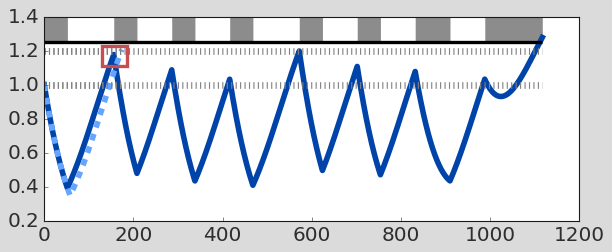

In [348]:
plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1,1,figsize=(8,3.5))
Plot_method(model_26.resultsDf, ax=ax, color = colors['AT'], linewidth=5)
Plot_method(model_29.resultsDf, ax=ax, color = false_col, plot_drug = False, linestyle = '--', linewidth=5)

# Add the patch to the Axes
ax.add_patch(Rectangle((130, 1.11), 55, 0.12, linewidth=3, edgecolor='r', facecolor='none', zorder=10));


ax.set_xlim(0, 1200); ax.set_ylim(0.2, 1.4)
plt.savefig("../figures/SI_AT_failure.pdf")

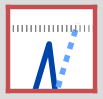

In [352]:
fix, ax = plt.subplots(1,1,figsize=(2.4,2))
Plot_method(model_26.resultsDf, ax=ax, color = colors['AT'])
Plot_method(model_29.resultsDf, ax=ax, color = false_col, plot_drug = False, linestyle = '--')

ax.set_ylim(1.11, 1.23); ax.set_xlim(130, 185)
plt.gca().set_xticklabels([]); plt.gca().set_yticklabels([]);
ax.xaxis.set_ticks_position('none'); ax.yaxis.set_ticks_position('none') ;
for label in ['bottom', 'top', 'right', 'left']:
    ax.spines[label].set_color('r')
ax.tick_params(axis='x', colors='w')
plt.setp(ax.spines.values(), linewidth=4);
plt.savefig("../figures/SI_inset_AT_failure.pdf")

In [249]:
threshold_vals = np.linspace(0.55, 0.95, 30)
tau_gap = 2

for threshold in threshold_vals:
    tau = calc_critical_treatment_interval(n_crit=modelParamDic['n0']*threshold, **modelParamDic)

    model_26 = LotkaVolterraModel(method='RK45')
    model_26.SetParams(**modelParamDic)
    model_26.Simulate_AT(atThreshold=threshold, intervalLength=int(tau)-1, t_end=5000, atMethod='Threshold');
    model_26.Trim(dt=1)

    model_29 = LotkaVolterraModel(method='RK45')
    model_29.SetParams(**modelParamDic)
    model_29.Simulate_AT(atThreshold=threshold, intervalLength=int(tau)+ tau_gap, t_end=5000, atMethod='Threshold');
    model_29.Trim(dt=1)

    ttp_diff = model_29.resultsDf['Time'].iloc[-1] - model_26.resultsDf['Time'].iloc[-1]
    print(f"Threshold: {threshold:.2f}, TTP diff: {ttp_diff:.2f}, Min TTP: {model_29.resultsDf['Time'].iloc[-1]:.2f}")


Threshold: 0.55, TTP diff: -34.00, Min TTP: 1495.00
Threshold: 0.56, TTP diff: -32.00, Min TTP: 1461.00
Threshold: 0.58, TTP diff: -27.00, Min TTP: 1511.00
Threshold: 0.59, TTP diff: 57.00, Min TTP: 1557.00
Threshold: 0.61, TTP diff: -20.00, Min TTP: 1519.00
Threshold: 0.62, TTP diff: 60.00, Min TTP: 1559.00
Threshold: 0.63, TTP diff: -86.00, Min TTP: 1519.00
Threshold: 0.65, TTP diff: -81.00, Min TTP: 1574.00
Threshold: 0.66, TTP diff: -4.00, Min TTP: 1605.00
Threshold: 0.67, TTP diff: 1.00, Min TTP: 1632.00
Threshold: 0.69, TTP diff: 72.00, Min TTP: 1655.00
Threshold: 0.70, TTP diff: 8.00, Min TTP: 1607.00
Threshold: 0.72, TTP diff: -117.00, Min TTP: 1583.00
Threshold: 0.73, TTP diff: -44.00, Min TTP: 1663.00
Threshold: 0.74, TTP diff: -37.00, Min TTP: 1673.00
Threshold: 0.76, TTP diff: -1472.00, Min TTP: 180.00
Threshold: 0.77, TTP diff: -1614.00, Min TTP: 177.00
Threshold: 0.78, TTP diff: -15.00, Min TTP: 1766.00
Threshold: 0.80, TTP diff: -60.00, Min TTP: 1759.00
Threshold: 0.81, 

## Panel B- Define concept of critical threshold

In [ ]:
def PlotDrug(dataDf, ax, color, plotDrugAsBar=True, currDrugBarPosition = 1.2, drugBarHeight = 0.2, line_max=None, **kwargs):
    # Generate drug data as time series from list
    drugConcentrationItem = TreatmentListToTS(treatmentList=ExtractTreatmentFromDf(dataDf),
                                                    tVec=dataDf['Time'])
    try:
        drugConcentrationVec += drugConcentrationItem
        max_dose = max(max_dose, np.max(drugConcentrationItem))
    except UnboundLocalError:
        drugConcentrationVec = drugConcentrationItem
        max_dose = np.max(drugConcentrationItem)

    # Plot as bars across top of plot. Cleaner, but can be harder to see alignment with tumour trajectory.
    # Rescale to make it fit within the bar at the top of the plot
    drugConcentrationVec = drugConcentrationVec * drugBarHeight + currDrugBarPosition
    line_max = dataDf['Time'].max() if line_max is None else line_max
    ax.fill_between(x=dataDf['Time'], y1=currDrugBarPosition, y2=drugConcentrationVec, linewidth=0.0,
                     alpha=0.5, step="post", label="Drug Concentration", color=color, **kwargs)
    ax.hlines(xmin=dataDf['Time'].min(), xmax=line_max, y=currDrugBarPosition, linewidth=3, color="black")
    ax.hlines(xmin=dataDf['Time'].min(), xmax=line_max, y=currDrugBarPosition + drugBarHeight, linewidth=3, color="black")


def Plot(df, legend=False, drug_label="Drug Concentration",
         ax=None, linewidth=5, drug_limit = None, **kwargs):
    if ax is None: fig, ax = plt.subplots(1, 1)
    currModelPredictionDf = pd.melt(df, id_vars=['Time'], value_vars=["TumourSize"])
    ax.plot(currModelPredictionDf['Time'], currModelPredictionDf['value'], linewidth=linewidth, **kwargs)

    PlotDrug(df, ax, 'k', plotDrugAsBar = True, currDrugBarPosition = 1.2, drugBarHeight = 0.2, line_max=drug_limit)

    # Format the plot
    ax.set_title(kwargs.get('title', ''))
    # plt.tight_layout()

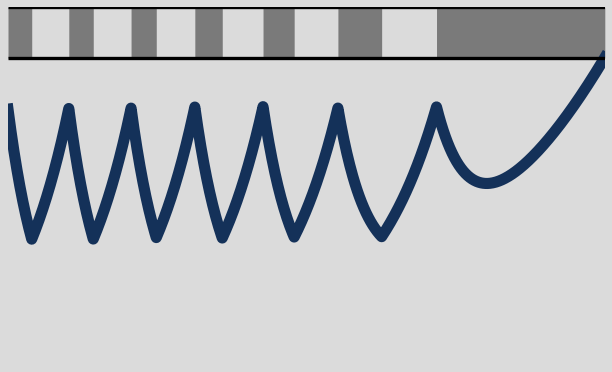

In [13]:
n0, r0 = 0.1, 0.003
cost, turnover = 0.4, 0.4
rs = 0.027  # From literature
t_max = 4000

fig, ax = plt.subplots(1, 1, figsize = (8,5))


model = LotkaVolterraModel(method='RK45', dt = 1)
paramDic = {"Cost": cost, "Turnover": turnover,
            "N0": n0, "R0": r0, "S0": (n0 - r0),
            "rS": rs, "rR": rs * (1-cost),
            "dS": rs * turnover, "dR": rs * turnover,
            'K': 1.5, 'DD': 1.5}
model.SetParams(**paramDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=t_max)
model.resultsDf[['TumourSize', 'S', 'R']] /= paramDic['N0']

Plot(model.resultsDf, ax=ax, legend=False, color = colors['AT'], linewidth=10)
# ax.add_patch(Rectangle((0, 0.5), model.ttp, 0.7, linewidth=0, alpha=0.5, facecolor='k', zorder=0));

# ax.hlines(xmin=0, xmax=model.ttp, y=1.2, linewidth=3, color="black")
# ax.hlines(xmin=0, xmax=model.ttp, y=0.5, linewidth=3, color="black")

ax.set_xticks([]); ax.set_yticks([]); ax.axis('off')
ax.set_xlim(0, model.ttp); ax.set_ylim(0, 1.4); 
ax.tick_params(top=False, right=False)

plt.tight_layout()
plt.savefig("figures/SI_crit_treatment_diagram.pdf")

## Panel C - Critical treatment interval

/home/gallagher/Documents/rotation_project/AT_Model_Comparison/lotka_volterra/../utils/myUtils.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  log_2 = (prog * S0) / (n_crit)


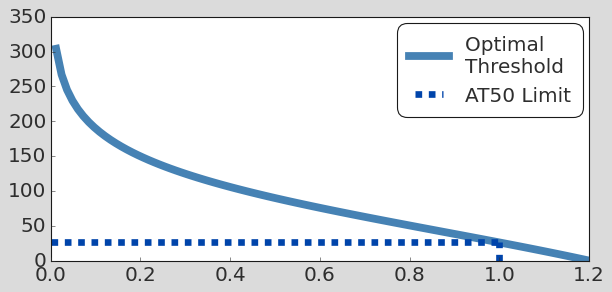

In [354]:
plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1,1,figsize=(8,4))

n_crit_vals = np.linspace(0, 1.2, 100); 

at_tau = calc_critical_treatment_interval(n_crit=1 * modelParamDic['n0'], **modelParamDic)

tau_high_turnover = [calc_critical_treatment_interval(n_crit=n * modelParamDic['n0'], **modelParamDic)
               for n in n_crit_vals]
plt.plot(n_crit_vals, tau_high_turnover, linewidth = 7, label = 'Optimal \nThreshold', color='steelblue'); 

ax.hlines(xmin=0, xmax=1, y=at_tau, linestyles="--", linewidth=6, color=colors['AT'], label = 'AT50 Limit')
ax.vlines(ymin=0, ymax=at_tau, x=1, linestyles="--", linewidth=6, color=colors['AT'])

ax.tick_params(right = False, top = False)
plt.gca().legend(loc=1, fontsize=18, numpoints=1).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.ylim(bottom=0)
plt.tight_layout(); plt.savefig("../figures/SI_analytic_interval.pdf")